# Image Classifier using CNN

In this exercise I build an image classifier model using convolutional neural networks. Using pictures downloaded from the internet, I fine-tune the pretrained model to identify cats, dogs, and mouses. You can use the live version of this model by clicking the below button:

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/vektor8891/animal-voila/HEAD?urlpath=%2Fvoila%2Frender%2Fanimal_classifier.ipynb)

In [1]:
# setup
from fastbook import *
from fastai.vision.all import *

## Download & Clean Images

In [17]:
# load api key
with open('private/credentials.json') as f:
    data = json.load(f)
    key = data['api-key']

In [18]:
# download images
sub_types = 'cat','dog','mouse'
path = Path('animals')

if not path.exists():
    path.mkdir()
for o in sub_types:
    print(o)
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    results = search_images_bing(key, o)
    download_images(dest, urls=results.attrgot('contentUrl'))

cat
dog
mouse


In [19]:
# delete unverified images
fns = get_image_files(path)
failed = verify_images(fns)
failed.map(Path.unlink)

(#9) [None,None,None,None,None,None,None,None,None]

## Build & Train Model

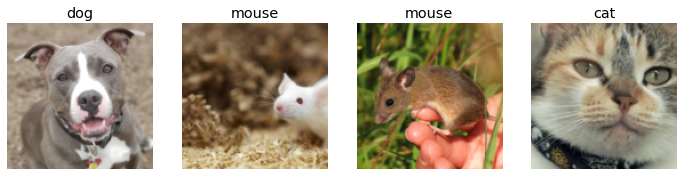

In [20]:
# create DataBlock
pics = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

dls = pics.dataloaders(path)

dls.valid.show_batch(max_n=4, nrows=1)

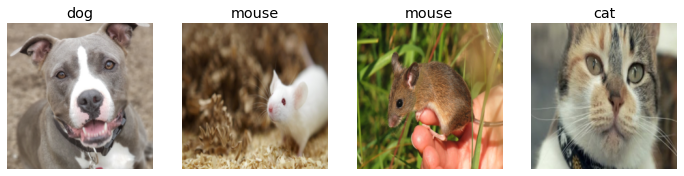

In [25]:
# augment training data
pics = pics.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms(mult=2))
dls = pics.dataloaders(path)

dls.valid.show_batch(max_n=4, nrows=1)

In [40]:
# convert png files to avoid transparency warning
# https://stackoverflow.com/questions/1233772/pil-does-not-save-transparency
from PIL import Image

for pic_path in dls.items:
    if str(pic_path).endswith('png'):
        print(pic_path)
        img = Image.open(pic_path)
        img = img.convert('RGBA')
        img.save(pic_path)

animals/cat/00000129.png
animals/mouse/00000058.png
animals/mouse/00000117.png
animals/mouse/00000078.png
animals/dog/00000062.png
animals/mouse/00000105.png
animals/mouse/00000064.png
animals/dog/00000051.png
animals/cat/00000073.png
animals/mouse/00000144.png
animals/dog/00000086.png
animals/dog/00000102.png
animals/mouse/00000086.png
animals/cat/00000074.png
animals/mouse/00000129.png


In [41]:
# train data
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.461377,0.585615,0.185185,00:15


epoch,train_loss,valid_loss,error_rate,time
0,0.354184,0.261373,0.098765,00:17
1,0.218513,0.130392,0.049383,00:17
2,0.161090,0.093816,0.024691,00:17
3,0.131655,0.085700,0.024691,00:16


In [42]:
# export model
learn.path = Path(os.getcwd())
learn.export()